In [1]:
# import pandas as pd
# from matplotlib import pyplot as plt
# from matplotlib import ticker
from read_data import create_df, create_dfV2, create_df_old, tic, toc
# import numpy as np

# pd.set_option('display.max_rows', 1000)

# # Generic plotting configurations
# plt.rcParams['figure.figsize'] = [10, 8]
# plt.style.use('ggplot')

In [3]:
# Select which experiments to plot
EXP = 'G9'
NREP = range(0,15)
NROB = [10,20,30]

# Collect data
df = create_df(EXP, 'block')

ValueError: No objects to concatenate

In [ ]:
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

# Create figure
bins = range(0,165,15)
xticks = range(0,165,15)

ax = plt.axes()
ax.grid(axis='x', linestyle='--') # vertical lines
ax.set_xticks(xticks) 
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

hist, bins = np.histogram(df['TELAPSED'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='w')

# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

plt.show()

In [4]:
# Select which experiment to plot
EXP = 'G9'
NREP = [0]
NROB = [30]
NBYZ = [0]

# Collect data
df = create_df(EXP, 'estimate')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

# Create figure
ax = plt.axes()

# Plot actual value
handle1 = plt.axhline(0.25, color='k', linestyle='--', linewidth=1.5)
# Plot each robot estimate
handle2 = df.set_index(['TIME']).groupby(['ID'])['ESTIMATE'].plot(color='grey', alpha=0.25)
handle2.label = 'Robot Estimates'
# Plot mean of robot estimates 
handle3 = df[['TIME', 'ESTIMATE']].sort_values('TIME').reset_index().groupby(df.index // NROB).mean().set_index('TIME')['ESTIMATE'].plot(color='r', linestyle='--', linewidth=2.5)
handle3.label = 'Robot Estimates (Mean, incl. Byzantines)'
# Plot excluding Byzantines
handle4 = df[['TIME', 'ESTIMATE']].sort_values('TIME').reset_index().replace(0,np.NaN).groupby(df.index // NROB).mean().set_index('TIME')['ESTIMATE'].plot(color='b', linestyle='--', linewidth=2.5)
handle4.label = 'Robot Estimates (Mean, excl. Byzantines)'

df = create_df(EXP, 'sc')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

df['BSTAMPS'] = df['BLOCK'].mul(15*1000) 
df['MEAN'] = df['MEAN'].div(10000000) 
handle5 = df.groupby(['BLOCK'])[['BSTAMPS', 'MEAN']].max().set_index('BSTAMPS').plot(ax=ax, color='g', linestyle='--', linewidth=2.5)
handle5.label = 'Blockchain Estimate'

# Edit figure looks
ax.set_ylim(ymin=0, ymax=0.5)
ax.set_title('Experiment_{} || {}rob-{}byz-{}'.format(EXP, NROB, NBYZ, NREP), fontsize=18)
# ax.legend()
plt.show()

ValueError: No objects to concatenate

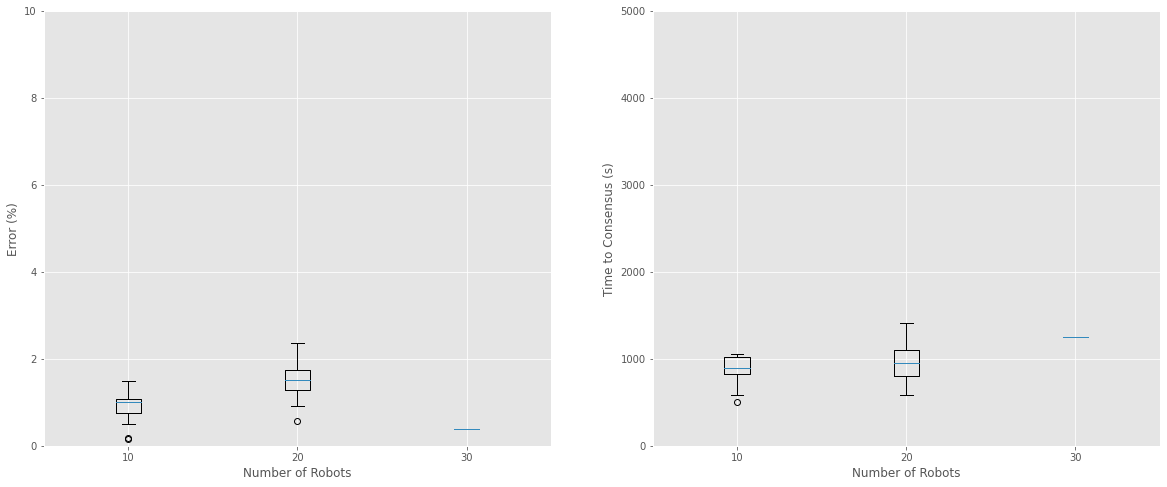

In [4]:
# Select which experiment to plot
EXP = 'G10'
NREP = range(0,15)
NROB = [10, 20, 30]

# Collect data
df = create_df(EXP, 'sc')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

# Create figure
fig, ax = plt.subplots(1,2, figsize=(20, 8))

# Big group for each box: Number of robots
boxes = df.groupby('NROB')

for x, box in boxes:
    errors = box.sort_values('TIME').groupby('NREP')['MEAN'].agg(['last']) # not 100% correct yet
    errors = errors.div(10000000).sub(0.25).abs().mul(100)

    cts = box[(box['C?']==True)].sort_values('TIME').groupby('NREP')['TIME'].agg(['first'])
    cts = cts.div(1000)
    
    # Plot boxplots for errors
    ax[0].boxplot(errors['last'], positions=[x/10])
    # Plot boxplots for consensus times
    ax[1].boxplot(cts['first'], positions=[x/10])
    
# Edit figure looks
ax[0].set_ylim(ymin=0, ymax=10)
ax[1].set_ylim(ymin=0, ymax=5000)
ax[0].set_xticklabels(NROB)
ax[1].set_xticklabels(NROB)
ax[0].set_ylabel('Error (%)')
ax[1].set_ylabel('Time to Consensus (s)')
ax[0].set_xlabel('Number of Robots')
ax[1].set_xlabel('Number of Robots')
plt.show()


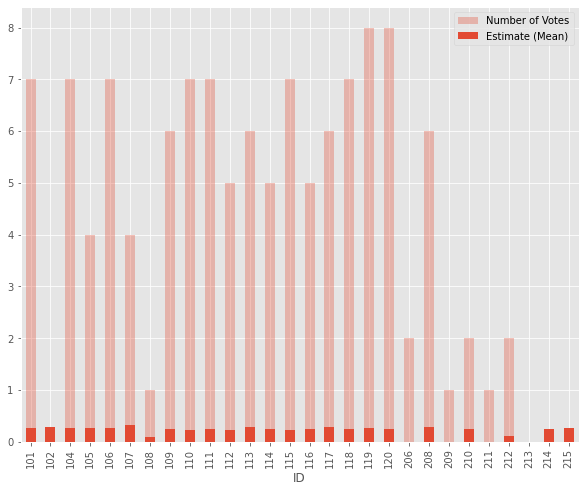

In [5]:
# Select which experiment to plot
EXP = 'G11'
NREP = [0]
NROB = [27]
pd.set_option('display.max_rows', 5000)

# Collect data
df = create_df(EXP, 'sc')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")
# display(df)

# Create figure
ax = plt.axes()

df.set_index(['ID']).groupby(['ID'])['#MYOKVOTES'].agg(['max']).plot.bar(ax=ax, alpha=0.33)

# Collect data
df = create_df(EXP, 'estimate')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")

df.set_index(['ID']).groupby(['ID'])['ESTIMATE'].agg(['mean']).plot.bar(ax=ax)

plt.legend(['Number of Votes', 'Estimate (Mean)'])
plt.show()

In [6]:
from graphviz import Digraph
import pydotplus
import networkx as nx
from networkx.algorithms.shortest_paths.generic import shortest_path as get_mainchain

# Construct digraph
def create_digraph(df):
    # Default settings for blockchain viz
    digraph = Digraph(comment='Blockchain', 
                      edge_attr={'arrowhead':'none'},
                      node_attr={'shape': 'record', 'margin': '0', 'fontsize':'9', 'height':'0.35', 'width':'0.35'}, 
                      graph_attr={'rankdir': 'LR', 'ranksep': '0.1', 'splines':'ortho'})
    

#     df.apply(lambda row : digraph.node(row['HASH'], str(row['BLOCK'])), axis = 1)
    digraph.node(df['PHASH'].iloc[0], '<f0> {} | <f1> {}'.format(df['PHASH'].iloc[0][2:6], 'Genesis'))
    df.apply(lambda row : digraph.node(row['HASH'], '<f0> {} | <f1> {}'.format(row['HASH'][2:6], str(row['BLOCK']))), axis = 1)
    df.apply(lambda row : digraph.edge(row['PHASH'], row['HASH']), axis = 1)
    
    return digraph

def convert_digraph(digraph):
    return nx.nx_pydot.from_pydot(pydotplus.graph_from_dot_data(digraph.source))

# Remove childless blocks
def trim_chain(df, levels=1):
    sub_df = df
    while levels:
        sub_df = sub_df.query('HASH in PHASH')
        levels -= 1
    return sub_df

def paths_longer_than(paths, n):
    return [x for x in paths if len(x)>=n]

def nodes_in_paths(paths):
    return [item for sublist in paths_longer_than(fork_paths, MIN_FORK_LENGTH) for item in sublist]

In [7]:
# Select which experiment to plot the whole blockchain
tic()
EXP = 'G10'
NREP = [0]
NROB = [30]
ID = [105]

# Collect data
df = create_df(EXP, 'block')
df = df.query("NROB in @NROB")
df = df.query("NREP in @NREP")
# df = df.query("ID in @ID")

# Remove duplicate blocks
df = df.drop_duplicates('HASH').sort_values('BLOCK')
genesis = df['PHASH'].iloc[0]

# df = trim_chain(df, 5)
bc = create_digraph(df)
bc_nx = convert_digraph(bc)
toc()

mainchain_path = get_mainchain(bc_nx, source=genesis, target=str(df['HASH'].iloc[-1]))

# Block hashes which are in mainchain_path -> mainchain 
df_mainchain = df.query("HASH in @mainchain_path")
# Block hashes not in the mainchain_path -> forks
df_forks = df.query("HASH not in @mainchain_path")
forks = create_digraph(df_forks)
forks_nx = convert_digraph(forks)
# Fork block hashes which are not parents -> leafs
df_leafs = df_forks.query('HASH not in PHASH')
# Fork block hashes which are parents but not children -> roots
df_roots = df_forks.query('PHASH not in HASH')

toc()

2.8266680240631104
3.74947452545166


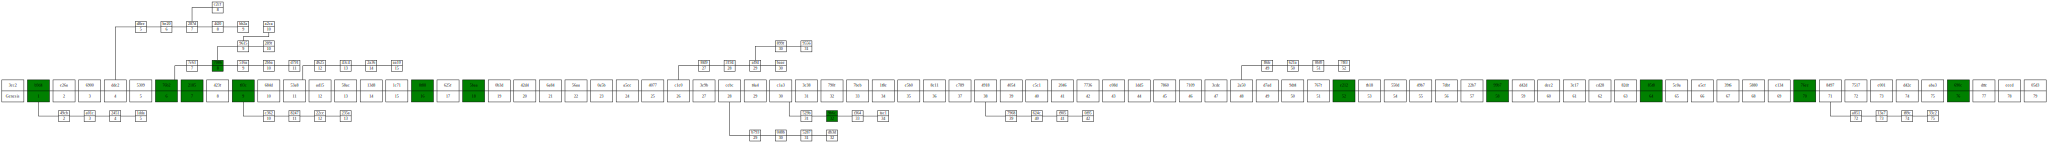

In [15]:
MIN_FORK_LENGTH = 4

fork_paths = [[y] for y in df_leafs['HASH']]
df_roots.apply(lambda row : fork_paths.extend(nx.all_simple_paths(forks_nx, row['HASH'], list(df_leafs['HASH']))), axis = 1)

nodes_in_forks_longer_than = nodes_in_paths(fork_paths)

df_trimmed = df.query('HASH in @nodes_in_forks_longer_than or HASH in @mainchain_path')
bc_trimmed = create_digraph(df_trimmed)

# Do something cool? Idk, for example mainchain in blue or make it bigger
df_trimmed.query('HASH in @mainchain_path').apply(lambda row : bc_trimmed.node(row['HASH'], height='0.7', width='0.7'), axis = 1)
bc_trimmed.node(genesis, height='0.7', width='0.7')

# Do something cool? Idk, for example color blocks sealed by prefered sealer in green. 
df_trimmed.query('DIFF==2').apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='green'), axis = 1)

# Do something cool? Idk, for example try to make mainchain at same level
df_trimmed.query('HASH in @mainchain_path').apply(lambda row : bc_trimmed.node(row['HASH'], group='main'), axis = 1)
bc_trimmed.node(genesis, group='main')

# # Do something cool? Idk, for example try to keep all forks at same level (very slow!)
df_trimmed.query('HASH in @nodes_in_forks_longer_than').apply(lambda row : bc_trimmed.node(row['HASH'], group='forks'), axis = 1)

bc_trimmed

# bc_trimmed.render('test-output/blockchain.gv', view=True)